# Gambler's ruin in Astro: beware of the Gaussian approximation!

Recently, I was on a holiday trip with a friend, let's call him Nathan. While not exactly a gambling addict, Nathan likes to buy scratchcards every now and then. One of his favorite is called Astro; most newspapers shops in France sell them for €2 a piece, and there exists 12 different version, one for each astrological sign. While the sign itself does not modify the odds (at least I don't believe so), it is a brilliant marketing strategy as it encourages you to buy a few more tickets and distribute them to your friends born under a different star than yours. Nathan is a Sagittarius, and that day he acquired a set of tickets, including an extra Aquarius one that he gifted to me. As it turned out, all but one of the set were loosers, the Aquarius one being the sole winner of a modest €6. Emboldened by this unexpected luck, I exchanged my gains for three more tickets to distribute among friends, keeping one Aquarius for myself. Again, all loosers but mine. This time I cashed out and stopped the gambling streak, much to Nathan's dismay. I admit this is not a particularly exciting vacation story, but it got me thinking: what if I did not cashed out? How long could I have last by just reinvesting my gains, flying off Nathan's initial €2 ticket?  

In [43]:
from IPython.core.display import HTML
display(HTML('<style>.container { width:95% !important; } </style>'))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import numpy as np
import pandas as pd
from collections import deque
from scipy.special import logsumexp
from scipy.stats import invgauss, norm, skew, kurtosis
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import pickle


SEED = 42
rng = np.random.default_rng(SEED)

## The Astro distribution

Astro is a fairly transparent game: whoever takes the time to read the back of a ticket can learn all there is to know about the odds and possible profits. On mine, it read that 4,500,000 tickets were issued, among which 661,500 are winners for €2, 476,000 for €4, 150,000 for €6, 101,350 for €10, 45,000 for €20, 415 for €17T00, 8 for €1,000 and finally 3 extra lucky ones for €25,000. The figure below shows this gain distribution, with probabilities displayed in logarithmic scale for readability.

The expected gain of a ticket chosen uniformly at random (which I assume is how tickets are assigned to vendors) can be easily calculated from the above information and reads $\mathbb{E}[gain] = \sum_{x} x\mathbb{P}(gain=x) = 1.37$. After substracting the €2 cost of a ticket, the expected net payoff of a single Astro ticket is then $-0.63$. This makes perfect sense: the company that issues these tickets makes 63 cents on each, i.e about €2.3m in total.

In addition, we can also compute the variance with the formula $\sigma^2 = \mathbb{E}[gain^2] - \mathbb{E}[gain]^2$, which gives $\sigma\approx 20.67$.

In [45]:
init_cost = 2

# Astro numbers
N = 4500000
gains = [2, 4, 6, 10, 20, 100, 1000, 25000]
ns = [661500, 476000, 150000, 101350, 45000, 415, 8, 3]

# Add loss event
gains.insert(0, 0)
ns.insert(0, N - sum(ns))

ps = np.array(ns) / N
xs = init_cost - np.array(gains)


class Categorical:
    def __init__(self, xs, ps, rng=np.random.default_rng(0)):
        self.xs = xs
        self.ps = ps
        self.rng = rng
    
    def rvs(self, size=1):
        return self.rng.choice(self.xs, p=self.ps, size=size)
    
    @property
    def mean(self):
        return self.xs @ self.ps
    
    @property
    def var(self):
        return self.ps @ (self.xs ** 2) - self.mean ** 2

    @property
    def std(self):
        return np.sqrt(self.var)

    @property
    def skewness(self):
        return self.ps @ (self.xs - self.mean) ** 3 / self.var ** 1.5
        
    @property
    def kurtosis(self):
        return self.ps @ (self.xs - self.mean) ** 4 / self.var ** 2 - 3
    
    
    
class CategoricalNoReplacement:
    def __init__(self, gains, ns, init_cost, rng=np.random.default_rng(0), shuffle=True, no_restart=True):
        self.gains = gains
        self.ns = ns
        self.xs = -(np.concatenate([np.repeat([gain], n) for gain, n in zip(gains, ns)]) - init_cost)
        self.rng = rng
        self.shuffle = shuffle
        self.no_restart = no_restart
    
    def rvs(self, size=1):
        if isinstance(size, tuple):
            L = np.prod(size)
        else:
            L = size
        if L <= len(self.xs):
            return self.rng.choice(self.xs, replace=False, size=L, shuffle=self.shuffle).reshape(size)
        else:
            if self.no_restart:
                raise Exception("Cannot sample more than {} times without replacement!".format(len(self.xs)))
            ret = []
            l = len(self.xs)
            while L > len(self.xs):
                ret.append(self.rvs(size=l))
                L -= l
            ret.append(self.rvs(size=L))
            return np.concatenate(ret).reshape(size)
            
    @property
    def mean(self):
        return np.mean(self.xs)
    
    @property
    def var(self):
        return np.var(self.xs)

    @property
    def std(self):
        return np.std(self.xs)
    

distr = Categorical(xs, ps, rng=rng)
distr_nr = CategoricalNoReplacement(gains, ns, init_cost, rng=rng)

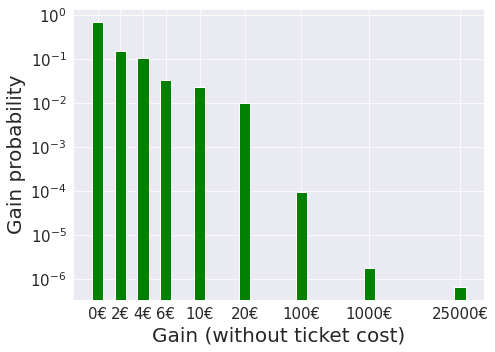

In [46]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
    
    xplot = [0., 1., 2., 3., 4.5, 6.5, 9., 12., 16.]
    
    ax.bar(xplot, distr.ps, width=0.5, color='green')

    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xlabel('Gain (without ticket cost)', fontsize=20)
    ax.set_ylabel('Gain probability', fontsize=20)
    
    ax.set_xticks(xplot)
    ax.set_xticklabels(['{:}€'.format(x) for x in -distr.xs + 2])
    ax.set_yscale('log')
    
    plt.tight_layout()
    plt.show()

## Flight time

Going back to our initial question: how long can we defy the odds and keep "flying" from only the initial investment of €2? Let's introduce some notations. We denote by $\left(g_t\right)_{t\in\mathbb{N}}$ a sequence of i.i.d samples drawn from the Astro distribution and let $\xi_t = 2 - g_t$ be the corresponding net *loss*, including the ticket price, and 
$$
X_t = \sum_{s=1}^t \xi_s
$$
be the cumulative loss process. The more $X_t$ increases, the more losses the gambler suffers.

Note that the i.i.d assumption does not exactly hold: once a ticket is bought and scratched, it is removed from the pool of available tickets and cannot be acquired again, i.e. the true sampling is *without replacement*. We will see later that this only has a limited impact on the final result, which is quite intuitive: if you draw only a few samples, say a few dozens at most, with replacement, it is quite unlikely that you would sample twice the same among the $N=4,500,000$.

Our problem of "flight time" corresponds to studying the following random time: 
$$
\tau_{\alpha} = \inf \left\lbrace t\in\mathbb{N}, X_t \geq \alpha \right\rbrace,
$$
which is a stopping time with respect to the natural filtration $\left(\mathcal{F}_t\right)_{t\in\mathbb{N}}$ induced by the process $X$, i.e. $\mathcal{F}_t=\sigma\left( X_s, 0\leq s\leq t\right)$ (this means $\left\lbrace \tau_{\alpha} \geq t\right\rbrace$ is an event in $\mathcal{F}_t$ for all $t\in\mathbb{N}$, i.e. one knows from the information available at time $t$ whether or not the stopping event occured or not). Indeed, reaching the threshold $\alpha=2$ for the cumulative loss $X_t$ is equivalent to reaching €0 wealth for a gambler who starts at €2 and keeps scratching Astro at every round, which we informally defined as the "flight time" above.

## The Gaussian case

The reader versed in martingales will almost surely recognise this problem as an instance of gambler's ruin. Indeed, the distribution of $\tau_{\alpha}$ can be fully explicited when the increments $\xi$ are Gaussian. For completeness, we derive below this standard result using stochastic calculus.

For convenience, we consider the continuous time setting, i.e. $t\in\mathbb{R}_+$ instead of $t\in\mathbb{N}$ and define the process $Z$ as
\begin{align*}
&dZ_t = \mu dt + \sigma dW_t\,,\\
&Z_0=0\,,\\
\end{align*}
where $\mu=0.63$, $\sigma=20.67$ and $W$ is a standard Brownian motion with respect to the filtration $\mathcal{F}$. Intuitively, we retrieve the discrete time model by the correspondence $dt\approx 1$ and $dW_t \approx \xi_t$. The loss process $Z$ can be more directly expressed as
$$
Z_t = \mu t + \sigma W_t\,.
$$


### Of martingales and stopping times

Studying a stopping time can be quite hard, and coupling it with the right martingale is often the easiest approach. We recall here some basics results on the interplay between martingales and stopping times. For convenience, we denote by $\mathcal{T}$ either $\mathbb{N}$ or $\mathbb{R}_+$ (the elementary results presented here are essentially unchanged by moving to the continuous time setting).

First, a process $\left(M_t\right)_{t\in\mathcal{T}}$ is a martingale with respect to a filtration $\left(\mathcal{F}_t\right)_{t\in\mathcal{T}}$ if for all $t\in\mathcal{T}$, $M_t$ is $\mathcal{F}_t$-adapted, integrable and satisfies the equality
$$
\forall s\in\mathcal{T},\ \mathbb{E}\left[M_{t+s}\mid \mathcal{F}_t\right] = M_t\,.
$$

Intuitively, this means a martingale represents a *fair* game: it uses only information available at time $t$ ($\mathcal{F}_t$-adapted), and given this information, the estimation of future values of $M$ is exactly the current known value $M_t$ (this property is sometimes referred to as martingales being "constant in expectation").

The crucial property of martingales for the study of stopping times is called Doob's optional stopping theorem: for any $\mathcal{F}$-stopping time, the *stopped* process $\left(M_{t\wedge \tau}\right)_{t\in\mathcal{T}}$ is also a $\mathcal{F}$-martingale, where $t\wedge \tau$ represents the minimum between $t$ and $\tau$. By taking the expectation of the above equality applied to the stopped martingale, we obtain the following identity:
$$
\forall t\in\mathcal{T},\ \mathbb{E}\left[M_{t\wedge \tau}\right] = \mathbb{E}\left[M_0\right]\,.
$$

Ideally, we would like to have the simpler equality $\mathbb{E}\left[M_{\tau}\right] = \mathbb{E}\left[M_0\right]$ instead, which depending on the exact expression of $M$ can reveal key properties of $\tau$ (expectation or higher moments, density function...). It is therefore tempting to take the limit $t\rightarrow +\infty$ in the above and hope that one can swap limit and expectation. This holds under a variety of technical assumptions. A simple argument, which is enough for our purpose, is to use the dominated convergence theorem, provided $M_{t\wedge \tau}$ can be bounded by an integrable random variable independent of $t$.

### Building the right martingale

For $\lambda\in\mathbb{R}$, we define
$$
M^\lambda_t = \exp\left( \lambda W_t - \frac{\lambda^2}{2}t\right)\,.
$$
It is a standard result in stochastic calculus that $M^\lambda$ defines a $\mathcal{F}$-martingale (it follows from the expression of the moment generating function on the standard Gaussian distribution coupled with the fact that the law of $W_t$ is $\mathcal{N}\left(0, t\right)$). Moreover, it can be rewritten as $M^\lambda_t = \exp\left( \frac{\lambda}{\sigma} Z_t - (\frac{\lambda^2}{2} + \frac{\lambda \mu}{\sigma})t\right)$. The reason why this is the "right" martingale will become apparent soon: it will help us compute exponential moments of $\tau_{\alpha}$, also known as the Laplace transform, which fully characterises its distribution.

Note that $t\mapsto X_t$ is (almost-surely) continuous (since $t\mapsto W_t$ is), and therefore $Z_{\tau_{\alpha}}=\alpha$ on the event $\left\lbrace \tau_{\alpha} < \infty\right\rbrace$. As a consequence, it is straightforward to control $M^{\lambda}_{t\wedge \tau_{\alpha}}$ in the following way:
$$
\lvert M^\lambda_{t\wedge \tau_{\alpha}} \rvert \leq e^{\frac{\lambda}{\sigma} \max(Z_{t\wedge \tau_{\alpha}}, 0) } \leq e^{\frac{\lambda \alpha}{\sigma}}\,,
$$
which allows to use the dominated convergence theorem as discussed above. Thereofore, Doob's optional stopping theorem yields:
$$
\mathbb{E}[M^\lambda_{\tau_{\alpha}}]=\mathbb{E}[e^{\frac{\lambda \alpha}{\sigma} - (\frac{\lambda^2}{2} + \frac{\lambda \mu}{\sigma})\tau_{\alpha}}]=1\,.
$$
After rearranging termes, we obtain the identity
$$
\mathbb{E}[e^{-(\frac{\lambda^2}{2} + \frac{\lambda \mu}{\sigma})\tau_{\alpha}}] = e^{-\frac{\lambda \alpha}{\sigma}}\,.
$$
This is almost the Laplace transform of $\tau_{\alpha}$, which we define for $\beta>0$ as $\mathbb{E}[e^{-\beta \tau_{\alpha}}]$. Since $\tau_{\alpha}$ is nonnegative, this Laplace transform fully characterises its distribution. Solving $\beta = \frac{\lambda^2}{2} + \frac{\lambda \mu}{\sigma}$ in terms of $\lambda$ yields $\lambda=-\frac{\mu}{\sigma} + \sqrt{\frac{\mu^2}{\sigma^2} + 2\beta}$ for $\lambda\geq 0$, i.e.
$$
\mathbb{E}[e^{-\beta \tau_{\alpha}}] = e^{\frac{\alpha \mu}{\sigma^2}\left(1 - \sqrt{1 + \frac{2\sigma^2 \beta}{\mu^2}}\right)} \,.
$$

Besides characterising the distribution, the Laplace transform is also useful to compute the moments. Indeed, by differentiating w.r.t. $\beta$, we have that
$$
-\frac{\partial}{\partial \beta} \mathbb{E}[e^{-\beta \tau_{\alpha}}]\bigg|_{\beta=0} = \mathbb{E}[\tau_{\alpha}] = \frac{\alpha}{\mu}\,.
$$

After all these calculations, let's take a step back to reflect on what this result means. On average, a gambler reaches the critical threshold $\alpha=2$ after $\frac{\alpha}{\mu}=\frac{2}{0.63}\approx 3.17$ rounds. This is, perhaps quite surprisingly, very intuitive: if you start from €2 and loose on average $63$ cents each time you play, it should take you a bit more than 3 rounds to consume your initial €2. The above shows that this back-of-the-envelope calculation is exact in the continuous time Gaussian case. Moreover, this result is independent of the variance $\sigma^2$.

### Nice! Does this mean that I can play thrice at the cost of a single ticket most of the time?

Not at all! It is important to make the distinction here between *mean* and *median* flight times. Intuitively, the distribution of flight time $\tau_{\alpha}$ should be quite asymmetrical around its mean: events where large gains are made early (e.g. first ticket yields €100) will result in very large flight times but remain quite rare, while events of "early crashes" (the few tickets are loosers) are much more frequent. Therefore, the median flight time, i.e. the majority of flight times are below it, should be less than the mean flight time, which is driven upwards by the "early luck" outliers. This type of distribution is called *right-skewed*.

### Flight time distribution in the Gaussian case

The expression of the Laplace transform $\mathbb{E}[e^{-\beta \tau_{\alpha}}]$ reveals that $\tau_{\alpha}$ follows an Inverse Gaussian distribution $IG\left(\frac{\alpha}{\mu}, \frac{\alpha^2}{\sigma^2}\right)$, the density of which is given by:
$$
p_{\tau_{\alpha}}(t) = \sqrt{\frac{\alpha^2}{2\pi \sigma^2 t^3}} \exp\left(-\frac{\left(\mu t - \alpha\right)^2}{2\sigma^2 t} \right)
$$

We plot below this density for the Astro parameters ($\mu=0.63, \sigma=20.67, \alpha=2$), as well as the mean, the median, and the 5th, 25th, 75th and 95th percentiles. This distribution appears to be significantly right-skewed: even the 95th percentile is below the mean ($2.14$ versus $3.17$). In other words, it is really unlikely (less than 5% chance) that your flight time will be above 2 rounds, even though the mean flight time is above 3!

|          | $\mu$ | $\sigma$ | skewness | kurtosis |
|----------|-------|----------|----------|----------|
| Astro    | 0.63  | 20.67    | -1180    | 1426486  |
| Gaussian | 0.63  | 20.67    | 0        | 0        |

In [47]:
mu = distr.mean
sigma = distr.std

distr_gauss = norm(loc=mu, scale=sigma)

pd.DataFrame(
    np.round(
        [
            [mu, sigma, distr.skewness, distr.kurtosis],
            [distr_gauss.mean(), distr_gauss.std(), distr_gauss.stats(moments='skew')[0], distr_gauss.stats(moments='kurtosis')[0]],
        ], 
        2).reshape(2, 4),
    index=['Astro', 'Gaussian'],
    columns=['$\mu$', '$\sigma$', 'skewness', 'kurtosis'],
)

# TODO: skewness and kurtosis

,$\mu$,$\sigma$,skewness,kurtosis
Astro,0.63,20.67,-1179.66,1426486.05
Gaussian,0.63,20.67,0.00,0.00


## Approximate flight time by inverse Gaussian

In [48]:
mu_inv_gauss = sigma ** 2 / (init_cost * mu)
scale = init_cost ** 2 / sigma ** 2

distr_invgauss = invgauss(mu_inv_gauss, scale=scale) 

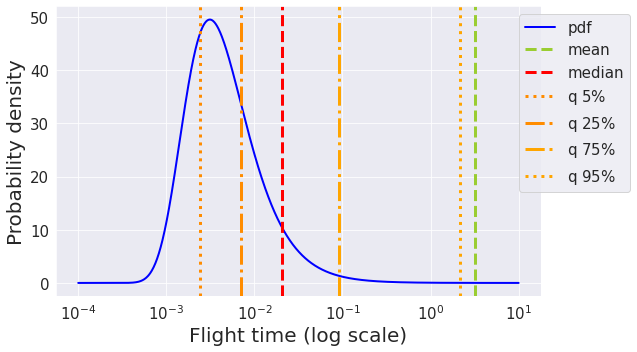

In [49]:
# g = lambda t: init_cost / sigma / np.sqrt(2 * np.pi * t ** 3) * np.exp(-(init_cost - mu * t) ** 2 / (2 * sigma ** 2 * t ))
tt = np.logspace(-4, 1, 1000)

with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(9, 5), nrows=1, ncols=1)
    
    ax.plot(tt, distr_invgauss.pdf(tt), color='blue', linewidth=2, label='pdf')
    
    ax.axvline(x=distr_invgauss.mean(), color='yellowgreen', linestyle='dashed', linewidth=3, label='mean')
    ax.axvline(x=distr_invgauss.median(), color='red', linestyle='dashed', linewidth=3, label='median')
    ax.axvline(x=distr_invgauss.ppf(0.05), color='darkorange', linestyle='dotted', linewidth=3, label='q $5\%$')
    ax.axvline(x=distr_invgauss.ppf(0.25), color='darkorange', linestyle='dashdot', linewidth=3, label='q $25\%$')
    ax.axvline(x=distr_invgauss.ppf(0.75), color='orange', linestyle='dashdot', linewidth=3, label='q $75\%$')
    ax.axvline(x=distr_invgauss.ppf(0.95), color='orange', linestyle='dotted', linewidth=3, label='q $95\%$')
    
#     ax.plot(tt, g(tt), color='red',  linestyle='dashed', linewidth=3, label='formula')

    ax.set_xscale('log')

    ax.legend(loc='upper right', prop={'size': 15}, bbox_to_anchor=(1.2, 1.0))
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xlabel('Flight time (log scale)', fontsize=20)
    ax.set_ylabel('Probability density', fontsize=20)
    
    plt.tight_layout()
    plt.show()

## Comparison between true Astro distribution and Gaussian approximation

In the previous post, we have calculated the distribution of the flight time of the cumulative Gaussian loss process $Z_t=\mu t + \sigma W_t$, that is $\tau_{\alpha} = \inf \left\lbrace t\in\mathbb{N}, Z_t \geq \alpha \right\rbrace$. In the game of Astro though, the loss distribution for scratching a card is far from being Gaussian: it is discrete, asymmetrical, with pronounced skewness towards small losses. The figure below shows the difference between the true Astro distribution (in green) and its Gaussian approximation $\mathcal{N}(\mu, \sigma^2)$ (in blue), with $\mu=0.63$ and $\sigma=20.67$.

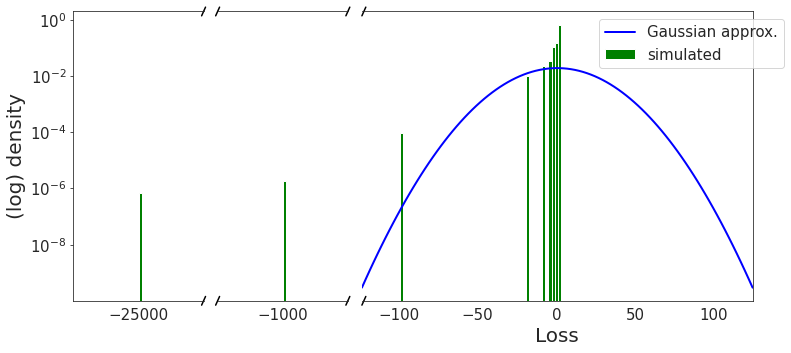

In [50]:
with sns.axes_style('white'):
    fig, (ax0, ax1, ax2) = plt.subplots(figsize=(11, 5), nrows=1, ncols=3, sharey=True, gridspec_kw={'width_ratios': [1, 1, 3]})
    
    xx1 = np.linspace(-25000 - 10, -25000 + 10, 100)
    ax0.bar(distr.xs[-1], distr.ps[-1], width=3, color='green', label='simulated')
    ax0.plot(xx1, norm(loc=mu, scale=sigma).pdf(xx1), color='blue', linewidth=2, label='Gaussian approx.')

    xx1 = np.linspace(-1000 - 80, -1000 + 80, 100)
    ax1.bar(distr.xs[-2], distr.ps[-2], width=3, color='green', label='simulated')
    ax1.plot(xx1, norm(loc=mu, scale=sigma).pdf(xx1), color='blue', linewidth=2, label='Gaussian approx.')

    xx2 = np.linspace(mu - 6 * sigma, mu + 6 * sigma, 100)
    ax2.bar(distr.xs, distr.ps, width=2, color='green', label='simulated')
    ax2.plot(xx2, norm(loc=mu, scale=sigma).pdf(xx2), color='blue', linewidth=2, label='Gaussian approx.')

    ax0.tick_params(axis='both', which='major', labelsize=15)
    ax1.tick_params(axis='both', which='major', labelsize=15)
    ax2.tick_params(axis='both', which='major', labelsize=15)
    
    ax0.set_ylabel('(log) density', fontsize=20)
    ax2.legend(loc='upper right', prop={'size': 15}, bbox_to_anchor=(1.1, 1.0))
    ax2.set_xlabel('Loss', fontsize=20)
    
    ax0.set_yscale('log')
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    
    ax0.set_xlim([-25000 - 60, -25000 + 60])
    ax1.set_xlim([-1000 - 80, -1000 + 80])
    ax2.set_xlim([mu - 6 * sigma, mu + 6 * sigma])
    
    ax0.set_xticks([-25000])
    ax1.set_xticks([-1000])
    

    d = .015  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax0.transAxes, color='k', clip_on=False)
    ax0.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)        # top-left diagonal
    ax0.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax1.transAxes)  # switch to the bottom axes
    ax1.plot((-d, +d), (-d, +d), **kwargs)  # bottom-left diagonal
    ax1.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal

    ax1.plot((1-d, 1+d), (-d, +d), **kwargs)  # bottom-left diagonal
    ax1.plot((1-d, 1+d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((0, d-d/3), (-d, +d), **kwargs)  # bottom-left diagonal
    ax2.plot((0, d-d/3), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal

    ax0.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax0.yaxis.tick_left()

    plt.tight_layout()
    plt.show()

It is insightful to look at the empirical estimation of $\mu$ and $\sigma$ under both the true Astro model and its Gaussian approximation. We define the standard (unbiased) sample estimators
\begin{align*}
&\widehat{\mu}_t = \frac{1}{t}\sum_{s=1}^t X_s \,,\\
&\widehat{\sigma}^2_t = \frac{1}{t-1}\sum_{s=1}^t \left(X_s - \widehat{\mu}_t\right)^2 \,,
\end{align*}
and report below the median (25th - 75th percentile in shaded area) of 10 independent replications of $\widehat{\mu}_t$ and $\widehat{\sigma}_t$ for $t$ ranging from 2 to 4,500,000, where $X$ is sampled from the Astro distribution (in green) and the Gaussian approximation (in blue).

In [51]:
T = int(4.5e6)
M = int(1e1)
tt = np.linspace(1, T, T)

astro_samples = distr.rvs(size=(M, T))
gauss_samples = rng.normal(loc=mu, scale=sigma, size=(M, T))
astro_nr_samples = np.empty((M, T))
for m in tqdm(range(M)):
    astro_nr_samples[m, :] = distr_nr.rvs(T)

astro_mu_hats = np.cumsum(astro_samples, axis=1) / tt
astro_nr_mu_hats = np.cumsum(astro_nr_samples, axis=1) / tt
astro_sigma_hats = np.sqrt(np.cumsum(astro_samples ** 2, axis=1) / tt - astro_mu_hats ** 2)

astro_nr_sigma_hats = np.sqrt(np.cumsum(astro_nr_samples ** 2, axis=1) / tt - astro_nr_mu_hats ** 2)
gauss_mu_hats = np.cumsum(gauss_samples, axis=1) / tt
gauss_sigma_hats = np.sqrt(np.cumsum(gauss_samples ** 2, axis=1) / tt - gauss_mu_hats ** 2)

# astro_mean = np.mean(astro_mu_hats, axis=0)
astro_mean = np.median(astro_mu_hats, axis=0)
astro_mean_q_25 = np.quantile(astro_mu_hats, q=0.25, axis=0)
astro_mean_q_75 = np.quantile(astro_mu_hats, q=0.75, axis=0)

# astro_std = np.mean(astro_sigma_hats, axis=0)
astro_std = np.median(astro_sigma_hats, axis=0)
astro_std_q_25 = np.quantile(astro_sigma_hats, q=0.25, axis=0)
astro_std_q_75 = np.quantile(astro_sigma_hats, q=0.75, axis=0)

# astro_nr_mean = np.mean(astro_nr_mu_hats, axis=0)
astro_nr_mean = np.median(astro_nr_mu_hats, axis=0)
astro_nr_mean_q_25 = np.quantile(astro_nr_mu_hats, q=0.25, axis=0)
astro_nr_mean_q_75 = np.quantile(astro_nr_mu_hats, q=0.75, axis=0)

# astro_nr_std = np.mean(astro_nr_sigma_hats, axis=0)
astro_nr_std = np.median(astro_nr_sigma_hats, axis=0)
astro_nr_std_q_25 = np.quantile(astro_nr_sigma_hats, q=0.25, axis=0)
astro_nr_std_q_75 = np.quantile(astro_nr_sigma_hats, q=0.75, axis=0)

# gauss_mean = np.mean(gauss_mu_hats, axis=0)
gauss_mean = np.median(gauss_mu_hats, axis=0)
gauss_mean_q_25 = np.quantile(gauss_mu_hats, q=0.25, axis=0)
gauss_mean_q_75 = np.quantile(gauss_mu_hats, q=0.75, axis=0)

# gauss_std = np.mean(gauss_sigma_hats, axis=0)
gauss_std = np.median(gauss_sigma_hats, axis=0)
gauss_std_q_25 = np.quantile(gauss_sigma_hats, q=0.25, axis=0)
gauss_std_q_75 = np.quantile(gauss_sigma_hats, q=0.75, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

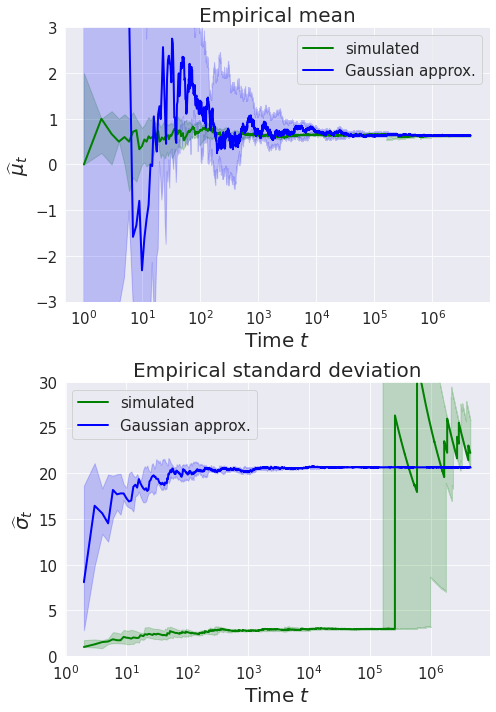

In [52]:
with sns.axes_style('darkgrid'):
    fig, axes = plt.subplots(figsize=(7, 10), nrows=2, ncols=1)
    
    ax = axes[0]
    ax.plot(tt, astro_mean, color='green', linewidth=2, label='simulated')
    ax.fill_between(tt, y1=astro_mean_q_25, y2=astro_mean_q_75, alpha=0.2, color='green')

#     ax.plot(tt, astro_nr_mean, color='orange', linewidth=2, label='simulated (nr)')
#     ax.fill_between(tt, y1=astro_nr_mean_q_25, y2=astro_nr_mean_q_75, alpha=0.2, color='orange')

    ax.plot(tt, gauss_mean, color='blue', linewidth=2, label='Gaussian approx.')
    ax.fill_between(tt, y1=gauss_mean_q_25, y2=gauss_mean_q_75, alpha=0.2, color='blue')

    ax.legend(loc='upper right', prop={'size': 15})
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xlabel('Time $t$', fontsize=20)
    ax.set_ylabel('$\widehat{\mu}_t$', fontsize=20)
    ax.set_title('Empirical mean', fontsize=20)
    
    ax.set_ylim([-3, 3])
    ax.set_xscale('log')
    
    ax = axes[1]
    ax.plot(tt[1:], astro_std[1:], color='green', linewidth=2, label='simulated')
    ax.fill_between(tt[1:], y1=astro_std_q_25[1:], y2=astro_std_q_75[1:], alpha=0.2, color='green')

#     ax.plot(tt[1:], astro_nr_std[1:], color='orange', linewidth=2, label='simulated (nr)')
#     ax.fill_between(tt[1:], y1=astro_nr_std_q_25[1:], y2=astro_nr_std_q_75[1:], alpha=0.2, color='orange')

    ax.plot(tt[1:], gauss_std[1:], color='blue', linewidth=2, label='Gaussian approx.')
    ax.fill_between(tt[1:], y1=gauss_std_q_25[1:], y2=gauss_std_q_75[1:], alpha=0.2, color='blue')

    ax.set_ylim([0, 30])
    ax.set_xscale('log')

    ax.legend(loc='upper left', prop={'size': 15})
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xlabel('Time $t$', fontsize=20)
    ax.set_ylabel('$\widehat{\sigma}_t$', fontsize=20)
    ax.set_title('Empirical standard deviation', fontsize=20)
    
    plt.tight_layout()
    plt.show()

For the mean estimation, as expected, $\widehat{\mu}_t$ converges to the true expected value $\mu=0.63$, with higher dispersion in the Gaussian case. For the variance estimation, $\widehat{\sigma}_t$ seems to converge quite fast to the true value $\sigma=20.67$ in the Gaussian case, but remains much lower in the Astro model until $t\approx 10^5$, before suddenly jumping to values around $\widehat{\sigma}_t\approx 20$. This is actually quite intuitive: the high variance of the Astro distribution is driven by the outlier gains, in particular 1,000 and 25,000, which occur with very small probability. Before $t\approx 10^5$, the samples $X_1, \dots, X_t$ used in $\widehat{\sigma}_t$ do not contain such outliers, thus estimating a seemingly low variance. In other words, the sample variance in the Astro model is subject to higher variability than in the Gaussian case, which hints at larger higher order moments (skewness, kurtosis...) in the Astro case.

In [14]:
T_short = int(1e2)
T_long = int(1e4)


def _empirical_short_log_laplace_transform(x):
    n = len(astro_mu_hats[:, T_short])
    return logsumexp(x * astro_mu_hats[:, T_short] - np.log(n))


def _empirical_short_log_laplace_transform_q_25(x):
    return np.quantile(x * astro_mu_hats[:, T_short], q=0.25)


def _empirical_short_log_laplace_transform_q_75(x):
    return np.quantile(x * astro_mu_hats[:, T_short], q=0.75)


def _empirical_long_log_laplace_transform(x):
    n = len(astro_mu_hats[:, T_long])
    return logsumexp(x * astro_mu_hats[:, T_long] - np.log(n))


def _empirical_long_log_laplace_transform_q_25(x):
    return np.quantile(x * astro_mu_hats[:, T_long], q=0.25)


def _empirical_long_log_laplace_transform_q_75(x):
    return np.quantile(x * astro_mu_hats[:, T_long], q=0.75)


empirical_short_log_laplace_transform = np.vectorize(_empirical_short_log_laplace_transform)
empirical_short_log_laplace_transform_q_25 = np.vectorize(_empirical_short_log_laplace_transform_q_25)
empirical_short_log_laplace_transform_q_75 = np.vectorize(_empirical_short_log_laplace_transform_q_75)

empirical_long_log_laplace_transform = np.vectorize(_empirical_long_log_laplace_transform)
empirical_long_log_laplace_transform_q_25 = np.vectorize(_empirical_long_log_laplace_transform_q_25)
empirical_long_log_laplace_transform_q_75 = np.vectorize(_empirical_long_log_laplace_transform_q_75)


def _empirical_nr_short_log_laplace_transform(x):
    n = len(astro_nr_mu_hats[:, T_short])
    return logsumexp(x * astro_nr_mu_hats[:, T_short] - np.log(n))


def _empirical_nr_short_log_laplace_transform_q_25(x):
    return np.quantile(x * astro_nr_mu_hats[:, T_short], q=0.25)


def _empirical_nr_short_log_laplace_transform_q_75(x):
    return np.quantile(x * astro_nr_mu_hats[:, T_short], q=0.75)


def _empirical_nr_long_log_laplace_transform(x):
    n = len(astro_nr_mu_hats[:, T_long])
    return logsumexp(x * astro_nr_mu_hats[:, T_long] - np.log(n))


def _empirical_nr_long_log_laplace_transform_q_25(x):
    return np.quantile(x * astro_nr_mu_hats[:, T_long], q=0.25)


def _empirical_nr_long_log_laplace_transform_q_75(x):
    return np.quantile(x * astro_nr_mu_hats[:, T_long], q=0.75)


empirical_nr_short_log_laplace_transform = np.vectorize(_empirical_nr_short_log_laplace_transform)
empirical_nr_short_log_laplace_transform_q_25 = np.vectorize(_empirical_nr_short_log_laplace_transform_q_25)
empirical_nr_short_log_laplace_transform_q_75 = np.vectorize(_empirical_nr_short_log_laplace_transform_q_75)

empirical_nr_long_log_laplace_transform = np.vectorize(_empirical_nr_long_log_laplace_transform)
empirical_nr_long_log_laplace_transform_q_25 = np.vectorize(_empirical_nr_long_log_laplace_transform_q_25)
empirical_nr_long_log_laplace_transform_q_75 = np.vectorize(_empirical_nr_long_log_laplace_transform_q_75)


def gaussian_short_log_laplace_transform(x):
    return mu * x + 0.5 * sigma ** 2 * x ** 2 / T_short

def gaussian_long_log_laplace_transform(x):
    return mu * x + 0.5 * sigma ** 2 * x ** 2 / T_long

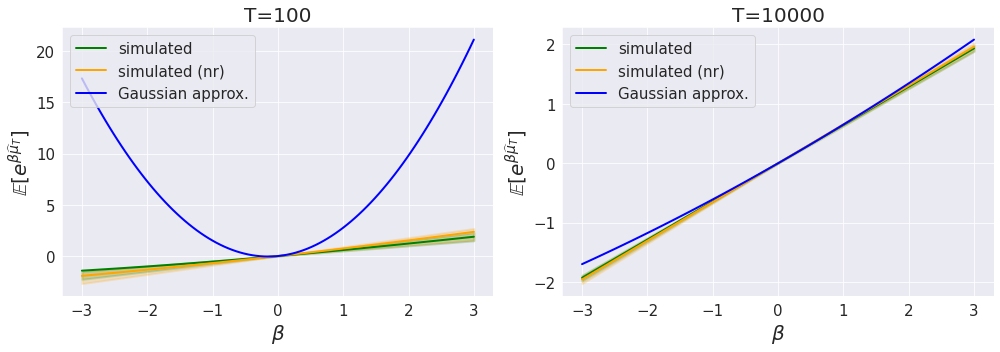

In [15]:
xx = np.linspace(-3, 3, 100)

with sns.axes_style('darkgrid'):
    fig, axes = plt.subplots(figsize=(14, 5), nrows=1, ncols=2)
    
    ax = axes[0]
    ax.plot(xx, empirical_short_log_laplace_transform(xx), color='green', linewidth=2, label='simulated')
    ax.fill_between(xx, y1=empirical_short_log_laplace_transform_q_25(xx), y2=empirical_short_log_laplace_transform_q_75(xx), alpha=0.2, color='green', linewidth=2)

    ax.plot(xx, empirical_nr_short_log_laplace_transform(xx), color='orange', linewidth=2, label='simulated (nr)')
    ax.fill_between(xx, y1=empirical_nr_short_log_laplace_transform_q_25(xx), y2=empirical_nr_short_log_laplace_transform_q_75(xx), alpha=0.2, color='orange', linewidth=2)

    ax.plot(xx, gaussian_short_log_laplace_transform(xx), color='blue', linewidth=2, label='Gaussian approx.')
    
    ax.legend(loc='upper left', prop={'size': 15})
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xlabel(r'$\beta$', fontsize=20)
    ax.set_ylabel(r'$\mathbb{E}[e^{\beta \widehat{\mu}_T}]$', fontsize=20)
    ax.set_title('T={:.0f}'.format(T_short), fontsize=20)
    
    ax = axes[1]
    ax.plot(xx, empirical_long_log_laplace_transform(xx), color='green', linewidth=2, label='simulated')
    ax.fill_between(xx, y1=empirical_long_log_laplace_transform_q_25(xx), y2=empirical_long_log_laplace_transform_q_75(xx), alpha=0.2, color='green', linewidth=2)

    ax.plot(xx, empirical_nr_long_log_laplace_transform(xx), color='orange', linewidth=2, label='simulated (nr)')
    ax.fill_between(xx, y1=empirical_nr_long_log_laplace_transform_q_25(xx), y2=empirical_nr_long_log_laplace_transform_q_75(xx), alpha=0.2, color='orange', linewidth=2)

    ax.plot(xx, gaussian_long_log_laplace_transform(xx), color='blue', linewidth=2, label='Gaussian approx.')
    
    ax.legend(loc='upper left', prop={'size': 15})
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xlabel(r'$\beta$', fontsize=20)
    ax.set_ylabel(r'$\mathbb{E}[e^{\beta \widehat{\mu}_T}]$', fontsize=20)
    ax.set_title('T={:.0f}'.format(T_long), fontsize=20)
    
    plt.tight_layout()
    plt.show()

## Simulation of categorical random walk hitting time

In [16]:
with open('results/astro_hitting_time_159071.pkl', 'rb') as f:
    res = pickle.load(f)
    unique = res['results']['unique'].astype('int32')
    counts = res['results']['counts'].astype('int32')
    unique_nr = res['results']['unique_nr'].astype('int32')
    counts_nr = res['results']['counts_nr'].astype('int32')
    samples = np.concatenate([np.repeat([u], n) for u, n in zip(unique, counts)])
    samples_nr = np.concatenate([np.repeat([u], n) for u, n in zip(unique_nr, counts_nr)])

In [17]:
len(samples) / 1e9

0.10000008

In [18]:
# def sample_tau(distr, thresh, size=1, t_max=4.5e6, buffer_size=100, verbose=False):
#     assert thresh > 0, "threshold must be > 0!"
#     samples = np.empty(size, dtype=int)
#     buffer_idx = 0
#     for i in tqdm(range(size), disable=not verbose):
#         # init random walk and hitting time
#         random_walk = 0.0
#         t = 0
        
#         while random_walk < thresh and t < t_max:
#             if buffer_idx % buffer_size == 0:
#                 increments = distr.rvs(size=buffer_size)
#             random_walk += increments[buffer_idx % buffer_size]
#             t += 1
#             buffer_idx += 1
#         samples[i] = t

#     return samples

# M = int(1e6)
# samples = sample_tau(distr, init_cost, buffer_size=100, size=M, verbose=True)
# samples_nr = sample_tau(distr_nr, init_cost, buffer_size=int(4.5e6), size=M, verbose=True)

In [28]:
bootstrap_indices

<generator object get_bootstrap_indices at 0x7fa6bc0c4c10>

In [32]:
# Homemade bootstrap implementation to save memory
# (scipy.bootstrap crashed with such large samples...)
rng = np.random.default_rng(1234)
def get_bootstrap_indices(data, n_resamples=10, rng=np.random.default_rng(0)):
    for _ in range(n_resamples):
        yield rng.choice(np.arange(len(data)), size=len(data), replace=True)


means_bootstrap = []
stds_bootstrap = []
q05s_bootstrap = []
q25s_bootstrap = []
q50s_bootstrap = []
q75s_bootstrap = []
q95s_bootstrap = []
n_resamples = 100
delta = 0.05

bootstrap_indices = get_bootstrap_indices(samples, n_resamples=n_resamples, rng=rng)
for indices in tqdm(bootstrap_indices, total=n_resamples):
    samples_ = samples[indices]
    means_bootstrap.append(np.mean(samples_))
    stds_bootstrap.append(np.std(samples_))
    q05s_bootstrap.append(np.quantile(samples_, q=0.05))
    q25s_bootstrap.append(np.quantile(samples_, q=0.25))
    q50s_bootstrap.append(np.quantile(samples_, q=0.5))
    q75s_bootstrap.append(np.quantile(samples_, q=0.75))
    q95s_bootstrap.append(np.quantile(samples_, q=0.95))
    
mean_bootstrap_ci = [np.quantile(means_bootstrap, q=delta / 2), np.quantile(means_bootstrap, q=1 - delta / 2)]
std_bootstrap_ci = [np.quantile(stds_bootstrap, q=delta / 2), np.quantile(stds_bootstrap, q=1 - delta / 2)]
q05_bootstrap_ci = [np.quantile(q05s_bootstrap, q=delta / 2), np.quantile(q05s_bootstrap, q=1 - delta / 2)]
q25_bootstrap_ci = [np.quantile(q25s_bootstrap, q=delta / 2), np.quantile(q25s_bootstrap, q=1 - delta / 2)]
q50_bootstrap_ci = [np.quantile(q50s_bootstrap, q=delta / 2), np.quantile(q50s_bootstrap, q=1 - delta / 2)]
q75_bootstrap_ci = [np.quantile(q75s_bootstrap, q=delta / 2), np.quantile(q75s_bootstrap, q=1 - delta / 2)]
q95_bootstrap_ci = [np.quantile(q95s_bootstrap, q=delta / 2), np.quantile(q95s_bootstrap, q=1 - delta / 2)]


  0%|          | 0/100 [00:00<?, ?it/s]

In [16]:
pd.DataFrame(
    np.round(
        [
            [np.mean(samples), np.std(samples), skew(samples), kurtosis(samples), np.quantile(samples, 0.05), np.quantile(samples, 0.25), np.quantile(samples, 0.5), np.quantile(samples, 0.75), np.quantile(samples, 0.95)],
            [np.mean(samples_nr), np.std(samples_nr), skew(samples_nr), kurtosis(samples_nr), np.quantile(samples_nr, 0.05), np.quantile(samples_nr, 0.25), np.quantile(samples_nr, 0.5), np.quantile(samples_nr, 0.75), np.quantile(samples_nr, 0.95)],
            [distr_invgauss.mean(), distr_invgauss.std(), distr_invgauss.stats(moments='s'), distr_invgauss.stats(moments='k'), distr_invgauss.ppf(0.05), distr_invgauss.ppf(0.25), distr_invgauss.ppf(0.5), distr_invgauss.ppf(0.75), distr_invgauss.ppf(0.95)],
        ],
        2
    ).reshape(3, -1),
    index=['simulated', 'simulated (nr)', 'gaussian approx'],
    columns=['mean', 'std_dev', 'skew', 'kurtosis','q_05', 'q_25', 'q_50', 'q_75', 'q_95'],
)

,mean,std_dev,skew,kurtosis,q_05,q_25,q_50,q_75,q_95
simulated,3.20,60.83,624.97,399632.31,1.0,1.00,1.00,2.00,11.00
simulated (nr),3.19,77.84,881.59,826114.16,1.0,1.00,1.00,2.00,11.00
gaussian approx,3.17,58.46,55.24,5085.98,0.0,0.01,0.02,0.09,2.14


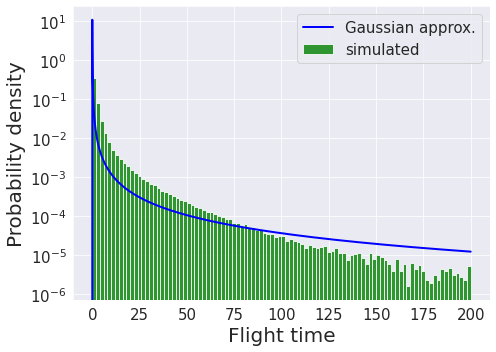

In [33]:
T = 200
tt = np.linspace(0, T, 10000)

with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
    
    ax.plot(tt, distr_invgauss.pdf(tt), color='blue', linewidth=2, label='Gaussian approx.')
    ax.hist(samples, bins=T // 2, range=[0, T], density=True, color='green', alpha=0.8, label='simulated')
#     ax.hist(samples_nr, bins=T // 2, range=[0, T], density=True, color='orange', alpha=0.8, label='simulated (nr)')
    
    ax.set_yscale('log')

    ax.legend(loc='upper right', prop={'size': 15})
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xlabel('Flight time', fontsize=20)
    ax.set_ylabel('Probability density', fontsize=20)
    
    plt.tight_layout()
    plt.show()

|                   | $\mu$              | $\sigma$           | 5th             | 25th            | 50th            | 75th            | 95th               |
|-------------------|--------------------|--------------------|-----------------|-----------------|-----------------|-----------------|--------------------|
| Astro (simulated) | 3.20 <br />[3.19 ; 3.21] | 60.8 [56.9 ; 64.1] | 1.0 [1.0 ; 1.0] | 1.0 [1.0 ; 1.0] | 1.0 [1.0 ; 1.0] | 2.0 [2.0 ; 2.0] | 11.0 [11.0 ; 11.0] |
| IG approximation   | 3.17               | 20.67              | 0.00            | 0.01            | 0.02            | 0.09            | 2.14               |





In [18]:
def _empirical_log_laplace_transform(x):
    n = len(samples)
    return logsumexp(-x * samples - np.log(n))

def _empirical_log_laplace_transform_q_25(x):
    return np.quantile(-x * samples, q=0.25)

def _empirical_log_laplace_transform_q_75(x):
    return np.quantile(-x * samples, q=0.75)

empirical_log_laplace_transform = np.vectorize(_empirical_log_laplace_transform)
empirical_log_laplace_transform_q_25 = np.vectorize(_empirical_log_laplace_transform_q_25)
empirical_log_laplace_transform_q_75 = np.vectorize(_empirical_log_laplace_transform_q_75)

def _empirical_nr_log_laplace_transform(x):
    n = len(samples_nr)
    return logsumexp(-x * samples_nr - np.log(n))

def _empirical_nr_log_laplace_transform_q_25(x):
    return np.quantile(-x * samples_nr, q=0.25)

def _empirical_nr_log_laplace_transform_q_75(x):
    return np.quantile(-x * samples_nr, q=0.75)

empirical_nr_log_laplace_transform = np.vectorize(_empirical_nr_log_laplace_transform)
empirical_nr_log_laplace_transform_q_25 = np.vectorize(_empirical_nr_log_laplace_transform_q_25)
empirical_nr_log_laplace_transform_q_75 = np.vectorize(_empirical_nr_log_laplace_transform_q_75)

def invgausslog_laplace_transform(x):
    return -init_cost / sigma * (-mu / sigma + np.sqrt(mu ** 2 / sigma ** 2 + 2 * x))

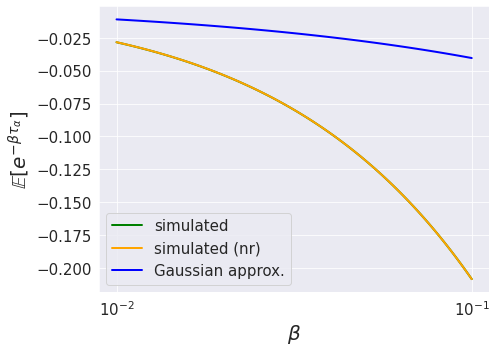

In [19]:
xx = np.logspace(-2, -1, 100)

with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
    
    ax.plot(xx, empirical_log_laplace_transform(xx), color='green', linewidth=2, label='simulated')
#     ax.fill_between(xx, y1=empirical_log_laplace_transform_q_25(xx), y2=empirical_log_laplace_transform_q_75(xx), alpha=0.2, color='green', linewidth=2)
    
    ax.plot(xx, empirical_nr_log_laplace_transform(xx), color='orange', linewidth=2, label='simulated (nr)')
#     ax.fill_between(xx, y1=empirical_nr_log_laplace_transform_q_25(xx), y2=empirical_nr_log_laplace_transform_q_75(xx), alpha=0.2, color='orange', linewidth=2)
    
    ax.plot(xx, invgausslog_laplace_transform(xx), color='blue', linewidth=2, label='Gaussian approx.')
    
    ax.set_xscale('log')

    ax.legend(loc='lower left', prop={'size': 15})
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xlabel(r'$\beta$', fontsize=20)
    ax.set_ylabel(r'$\mathbb{E}[e^{-\beta \tau_{\alpha}}]$', fontsize=20)
    
    plt.tight_layout()
    plt.show()